## Advanced Lane Finding Project

The goals / steps of this project are the following:

* [DONE] Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* [DONE] Apply a distortion correction to raw images.
* [DONE] Use color transforms, gradients, etc., to create a thresholded binary image.
* [DONE] Apply a perspective transform to rectify binary image ("birds-eye view").
* [DONE] Detect lane pixels and fit to find the lane boundary.
* [DONE] Determine the curvature of the lane and vehicle position with respect to center.
* [DONE] Warp the detected lane boundaries back onto the original image.
* [DONE] Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.
---
## First, I'll compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
# %matplotlib qt

%matplotlib inline


In [2]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('../camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

In [3]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

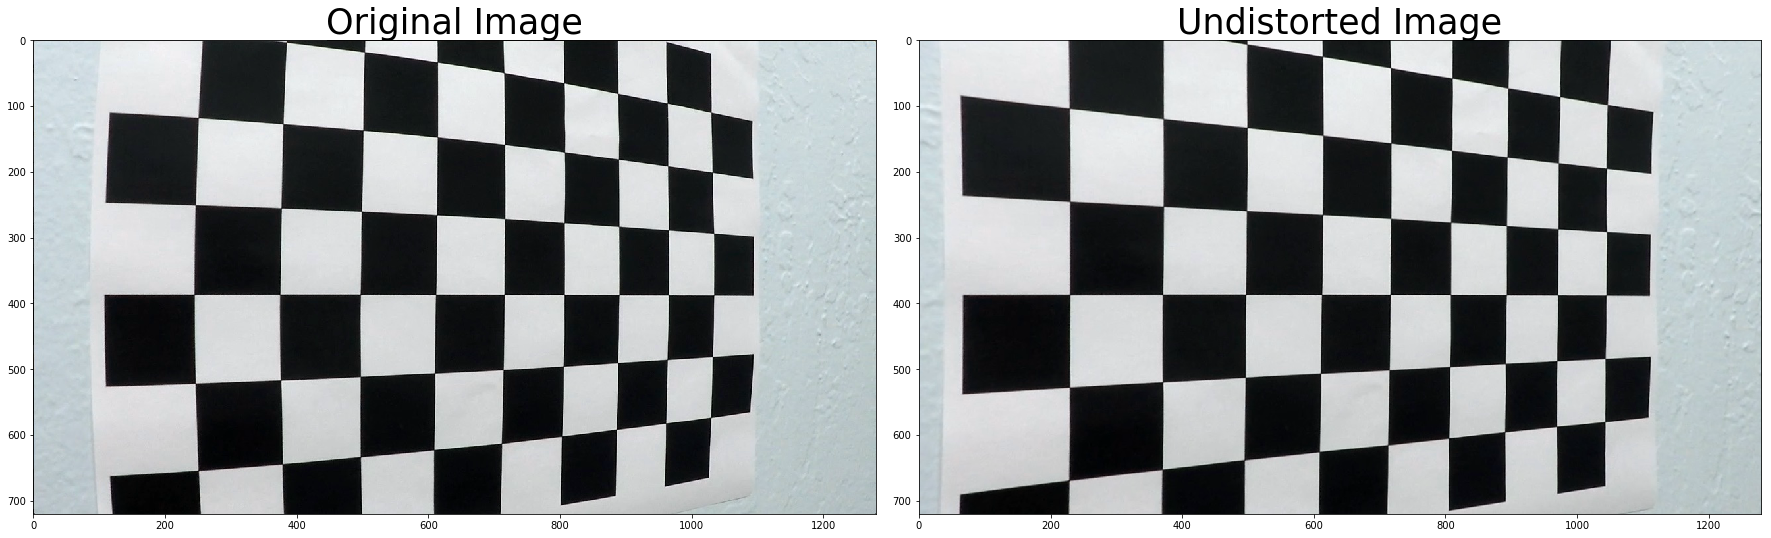

In [4]:
for fname in images[:1]:
    img = cv2.imread(fname)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=35)
    ax2.imshow(dst)
    ax2.set_title('Undistorted Image', fontsize=35)
    plt.subplots_adjust(left=0., right=1, top=0.8, bottom=0.)
    plt.savefig('./writeup_imgs/distortion_correction.png')

In [5]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(20, 100)):
    # Calculate directional gradient
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Applying sobel in direction 
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel) # Take the derivative in x
    elif orient == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel) # Take the derivative in x

    abs_sobel = np.absolute(sobel) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))

    # Threshold x gradient
    sbinary = np.zeros_like(scaled_sobel)
    sbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    return sbinary

def mag_thresh(image, sobel_kernel=3, thresh=(0, 255)):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Applying sobel in direction 
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel) # Take the derivative in x
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel) # Take the derivative in y

    abs_sobel = np.sqrt(sobelx**2 + sobely**2) 
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))

    # Threshold x gradient
    mag_binary = np.zeros_like(scaled_sobel)
    mag_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    return mag_binary

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    # 3) Take the absolute value of the x and y gradients
    abs_sobely = np.absolute(sobely)
    abs_sobelx = np.absolute(sobelx)
    
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    d = np.arctan2(abs_sobely, abs_sobelx)

    # scaled_sobel = np.uint8(255*d/np.max(d))
    binary_output = np.zeros_like(d)
    binary_output[(d >= thresh[0]) & (d <= thresh[1])] = 1
    
    return binary_output

In [6]:
class Line():
    
    def __init__(self):        
        self.left_fit_arr = [[], [], []]
        self.right_fit_arr = [[], [], []]
        self.curvature_arr = []
        self.center_diff_arr = []
        
        self.left_fit = None
        self.right_fit = None
        self.ploty = None
        
        self.img_height = 720
        self.img_width = 1280
        self.src_pnts = np.float32([(550, 465), (730, 465), (1090, 680), (210, 680)])

        offset = 100
        self.dst_pnts = np.float32([[offset, offset], [self.img_width-offset, offset], 
                                         [self.img_width-offset, self.img_height-offset], 
                                         [offset, self.img_height-offset]])
        
        self.M = cv2.getPerspectiveTransform(self.src_pnts, self.dst_pnts)
        self.Minv = cv2.getPerspectiveTransform(self.dst_pnts, self.src_pnts)

        self.ym_per_pix = 30/720 # meters per pixel in y dimension
        self.xm_per_pix = 3.7/700 # meters per pixel in x dimension

        self.frame_number = 0
    
    def find_lines(self, img):
        gradient_image = self.get_image_gradient(img)
        warped = self.apply_perspective_transform(gradient_image)
        ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )

        if self.frame_number > 0:
            self.left_fit, self.right_fit = self.find_line(warped, self.left_fit, self.right_fit)
        else:
            self.left_fit, self.right_fit = self.fine_first_lines(warped)
        
        self.frame_number += 1
        
        # For plotting the line
        left_fitx = self.left_fit[0]*ploty**2 + self.left_fit[1]*ploty + self.left_fit[2]
        right_fitx = self.right_fit[0]*ploty**2 + self.right_fit[1]*ploty + self.right_fit[2]
        
        result = self.draw_lines(img, warped, left_fitx, right_fitx, ploty)
        curvature, center_diff = self.get_curvature_offset(result, warped, left_fitx, right_fitx, ploty)
        
        # Using rolling average on curvature and center_diff values
        curvature, self.curvature_arr = self.average_value(curvature, self.curvature_arr)
        center_diff, self.center_diff_arr = self.average_value(center_diff, self.center_diff_arr)
        
        self.draw_curvature_offset(result, curvature, center_diff)
        
        return result
    
    
    def line_average(self, line_params, line_h_arr):
        line_params[0], line_h_arr[0] = self.average_value(line_params[0], line_h_arr[0])
        line_params[1], line_h_arr[1] = self.average_value(line_params[1], line_h_arr[1])
        line_params[2], line_h_arr[2] = self.average_value(line_params[2], line_h_arr[2])

        return line_params, line_h_arr
    
    def average_value(self, cur_val, val_arr, window=4):
        if len(val_arr) == window:
            val_arr.pop(0)
            val_arr.append(cur_val)
            next_val = np.average(val_arr)
        else:
            val_arr.append(cur_val)
            next_val = cur_val
        
        return next_val, val_arr
    
    def get_image_gradient(self, frame):
        undist = cv2.undistort(frame, mtx, dist, None, mtx)
        hls = cv2.cvtColor(undist, cv2.COLOR_RGB2HLS)
        s_channel = hls[:,:,2]

        # Choose a Sobel kernel size
        ksize = 3 # Choose a larger odd number to smooth gradient measurements

        # Apply each of the thresholding functions
        thresh_params = (50, 200)
        gradx = abs_sobel_thresh(undist, orient='x', sobel_kernel=ksize, thresh=thresh_params)
        grady = abs_sobel_thresh(undist, orient='y', sobel_kernel=ksize, thresh=thresh_params)
        mag_binary = mag_thresh(undist, sobel_kernel=ksize, thresh=thresh_params)
        dir_binary = dir_threshold(undist, sobel_kernel=15, thresh=(0.7, 1.3))

        combined = np.zeros_like(dir_binary)
        combined[((gradx == 1) & (grady == 1) ) | ((mag_binary == 1) & (dir_binary == 1) )] = 1


        # Threshold color channel
        s_thresh_min = 155
        s_thresh_max = 210
        s_binary = np.zeros_like(s_channel)
        s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

        # Combine the two binary thresholds
        combined_binary = np.zeros_like(combined)
        combined_binary[(s_binary == 1) | (combined == 1)] = 1
        
        return combined_binary
        
    def apply_perspective_transform(self, combined_binary):
        warped = cv2.warpPerspective(combined_binary, self.M, (self.img_width, self.img_height))
        return warped
    
    def find_line(self, binary_warped, right_fit, left_fit):
        # Assume you now have a new warped binary image 
        # from the next frame of video (also called "binary_warped")
        # It's now much easier to find line pixels!
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        margin = 100
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
        left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
        left_fit[1]*nonzeroy + left_fit[2] + margin))) 

        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
        right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
        right_fit[1]*nonzeroy + right_fit[2] + margin)))  

        # Again, extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
  
        return left_fit, right_fit
    
    def draw_lines(self, og_img, warped, left_fitx, right_fitx, ploty):
        # Drawing the lines over the og image  
        # Create an image to draw the lines on
        warp_zero = np.zeros_like(warped).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(color_warp, self.Minv, (frame.shape[1], frame.shape[0])) 
        # Combine the result with the original image
        result = cv2.addWeighted(og_img, 1, newwarp, 0.3, 0)
        
        return result
    
    def get_curvature_offset(self, image, warped, left_fitx, right_fitx, ploty):
        # Finding RADIOUS OF CURVATURE
        # Define conversions in x and y from pixels space to meters
        y_eval = np.max(warped)

        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(ploty*self.ym_per_pix, left_fitx*self.xm_per_pix, 2)
        right_fit_cr = np.polyfit(ploty*self.ym_per_pix, right_fitx*self.xm_per_pix, 2)
        # Calculate the new radii of curvature
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*self.ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*self.ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        curvature = (left_curverad + right_curverad)/2

        # Finding camera center
        camera_center = (left_fitx[-1] + right_fitx[-1])/2
        center_diff = (camera_center - warped.shape[1]/2)*self.xm_per_pix
        
        return curvature, center_diff
    
    def draw_curvature_offset(self, image, curvature, center_diff):
        side_pos = 'left'
        if center_diff <= 0:
            side_pos = 'right'

        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(image,'Radius of curvature: %.2f (m)' % curvature,(10,50), font, 1,(255,255,255),2,cv2.LINE_AA)
        cv2.putText(image,'Vehicle is %.2f (m) %s of the center' % (abs(center_diff), side_pos),(10,100), font, 1,(255,255,255),2,cv2.LINE_AA)

    
    def fine_first_lines(self, binary_warped):
        # Assuming you have created a warped binary image called "binary_warped"
        # Take a histogram of the bottom half of the image
        histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
        # Create an output image to draw on and  visualize the result
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]//2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        # Choose the number of sliding windows
        nwindows = 9
        # Set height of windows
        window_height = np.int(binary_warped.shape[0]//nwindows)
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base
        # Set the width of the windows +/- margin
        margin = 100
        # Set minimum number of pixels found to recenter window
        minpix = 50
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
            (0,1,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
            (0,1,0), 2) 
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 

        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)

        return left_fit, right_fit

In [7]:
# Code to read video frame by frame and process it using the Lane class

# cap = cv2.VideoCapture('../need_to_fix.mp4')
cv2.destroyAllWindows()
cap = cv2.VideoCapture('../project_video.mp4')

frame_width = int(cap.get(3))
frame_height = int(cap.get(4))
out = cv2.VideoWriter('outpy_f4.avi',cv2.VideoWriter_fourcc('M','J','P','G'), 30, (frame_width,frame_height))

line_finder = Line()
# Check if camera opened successfully
if (cap.isOpened()== False): 
    print("Error opening video stream or file")


# Read until video is completed
n_frame = 1
while(cap.isOpened()):
    # Capture frame-by-frame
    ret, frame = cap.read()
    if ret == True:
        
        # Writing out processed frames
#         out.write(line_finder.find_lines(frame))
        
        #Show the frame
        cv2.imshow('Frame', line_finder.find_lines(frame))
                
        # Press Q on keyboard to  exit
        if cv2.waitKey(25) & 0xFF == ord('q'):
            break
 
    # Break the loop
    else: 
        break



KeyboardInterrupt: 

In [47]:
# When everything done, release the video capture object
cap.release()
out.release()

# Closes all the frames
cv2.destroyAllWindows()